## Libraries

In [44]:
import requests
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates


## Fetching Data

In [52]:
endpoint_url = "https://financialmodelingprep.com/api/v3/historical-price-full/AAPL?apikey=wc2bbHWhFBL7no45kaUlx2xLHI2z2wv1"
response = requests.get(endpoint_url)
data = response.json()
print(data)

{'symbol': 'AAPL', 'historical': [{'date': '2024-04-02', 'open': 169.08, 'high': 169.34, 'low': 168.23, 'close': 168.94, 'adjClose': 168.94, 'volume': 33507036, 'unadjustedVolume': 33507036, 'change': -0.14, 'changePercent': -0.08280104, 'vwap': 168.8975, 'label': 'April 02, 24', 'changeOverTime': -0.0008280104}, {'date': '2024-04-01', 'open': 171.19, 'high': 171.25, 'low': 169.48, 'close': 170.03, 'adjClose': 170.03, 'volume': 46240500, 'unadjustedVolume': 46240500, 'change': -1.16, 'changePercent': -0.67761, 'vwap': 170.4875, 'label': 'April 01, 24', 'changeOverTime': -0.0067761}, {'date': '2024-03-28', 'open': 171.75, 'high': 172.23, 'low': 170.51, 'close': 171.48, 'adjClose': 171.48, 'volume': 65672690, 'unadjustedVolume': 65672690, 'change': -0.27, 'changePercent': -0.15721, 'vwap': 171.4925, 'label': 'March 28, 24', 'changeOverTime': -0.0015721}, {'date': '2024-03-27', 'open': 170.41, 'high': 173.6, 'low': 170.11, 'close': 173.31, 'adjClose': 173.31, 'volume': 60273265, 'unadjust

## data preprocessing


In [48]:

# Convert data to DataFrame
df = pd.DataFrame(data["historical"])
# indexing 
df.set_index('date', inplace=True)
df.to_csv('AAPL.csv')
df.head()
# print(df.describe())




,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
date,,,,,,,,,,,,
2024-04-02,169.08,169.34,168.23,168.94,168.94,33507036,33507036,-0.14,-0.082801,168.8975,"April 02, 24",-0.000828
2024-04-01,171.19,171.25,169.48,170.03,170.03,46240500,46240500,-1.16,-0.677610,170.4875,"April 01, 24",-0.006776
2024-03-28,171.75,172.23,170.51,171.48,171.48,65672690,65672690,-0.27,-0.157210,171.4925,"March 28, 24",-0.001572
2024-03-27,170.41,173.60,170.11,173.31,173.31,60273265,60273265,2.90,1.700000,171.8575,"March 27, 24",0.017000
2024-03-26,170.00,171.42,169.58,169.71,169.71,57388449,57388449,-0.29,-0.170590,170.1775,"March 26, 24",-0.001706


# plotting with format

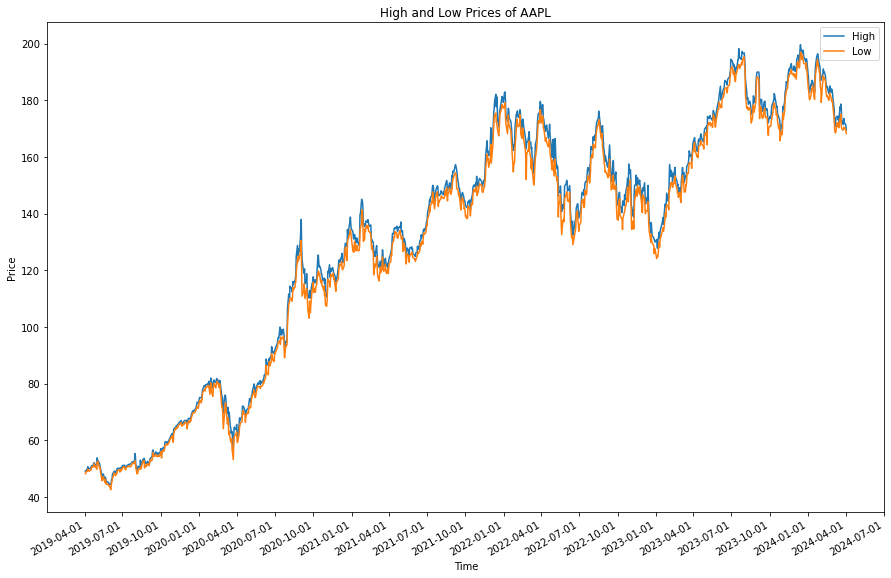

In [73]:


# Plotting
# Convert 'date' column to datetime
df.index = pd.to_datetime(df.index)

# Plotting
plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
x_dates = df.index

plt.plot(x_dates, df['high'], label='High')
plt.plot(x_dates, df['low'], label='Low')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('High and Low Prices of AAPL')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## Feature selection



In [75]:
df1 = df.reset_index()['close']
df1.head()
## change in indefx has messed the rest of the program below 



0    168.94
1    170.03
2    171.48
3    173.31
4    169.71
Name: close, dtype: float64

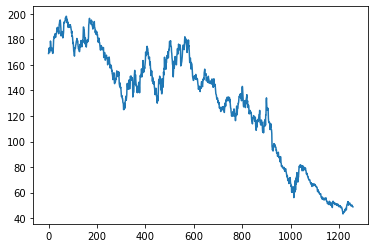

In [69]:
plt.plot(df1)


In [8]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
# After Transformation 
df1

array([[0.81153896],
       [0.81858121],
       [0.82794935],
       ...,
       [0.03824784],
       [0.03611578],
       [0.03559891]])

## Training (65%) and Testing (35%) 

In [10]:
Training_size = int(len(df1)*0.65)
test_size = len(df1)-Training_size

train_data, test_data = df1[0:Training_size,:], df1[Training_size:len(df1),:1]

## Converting from array to  matrix dataset

In [11]:

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)    

In [12]:
# reshaping
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

## Time series Dataset

In [13]:
print(X_train.shape), print(y_train.shape)

(717, 100)
(717,)


(None, None)

In [14]:
# Reshape Input to be [samples, timesteps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # 1 at the end is for the 3d
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


## Creating / Building the LSTM Model

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [16]:
# stacked model
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape =(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


# Training the model 

In [18]:
model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=50, batch_size=64, verbose=1)

Epoch 1/50
12/12 [==============================] - 8s 211ms/step - loss: 0.0768 - val_loss: 0.0067
Epoch 2/50
12/12 [==============================] - 1s 117ms/step - loss: 0.0118 - val_loss: 0.0309
Epoch 3/50
12/12 [==============================] - 1s 111ms/step - loss: 0.0054 - val_loss: 0.0273
Epoch 4/50
12/12 [==============================] - 1s 109ms/step - loss: 0.0043 - val_loss: 0.0204
Epoch 5/50
12/12 [==============================] - 1s 111ms/step - loss: 0.0033 - val_loss: 0.0192
Epoch 6/50
12/12 [==============================] - 1s 118ms/step - loss: 0.0031 - val_loss: 0.0166
Epoch 7/50
12/12 [==============================] - 1s 115ms/step - loss: 0.0029 - val_loss: 0.0142
Epoch 8/50
12/12 [==============================] - 1s 111ms/step - loss: 0.0027 - val_loss: 0.0116
Epoch 9/50
12/12 [==============================] - 1s 110ms/step - loss: 0.0026 - val_loss: 0.0096
Epoch 10/50
12/12 [==============================] - 1s 109ms/step - loss: 0.0026 - val_loss: 0.0086

## Prediction


In [62]:
tf.__version__

'2.9.1'

In [63]:
# prediction and checking performance
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 18ms/step


In [64]:
## transform back to original form 
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calcualting RMSE performance metrics

In [65]:
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))


154.70029260757474

In [66]:
# test data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

74.6965393587879

# Plotting

In [67]:
print("Shape of test_predict:", train_predict.shape)
print("Length of test_predict:", len(train_predict))

print("Shape of test_predict:", test_predict.shape)
print("Length of test_predict:", len(test_predict))

Shape of test_predict: (717, 1)
Length of test_predict: 717
Shape of test_predict: (341, 1)
Length of test_predict: 341


ValueError: Expected 2D array, got 1D array instead:
array=[168.94 170.03 171.48 ...  49.25  48.92  48.84].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

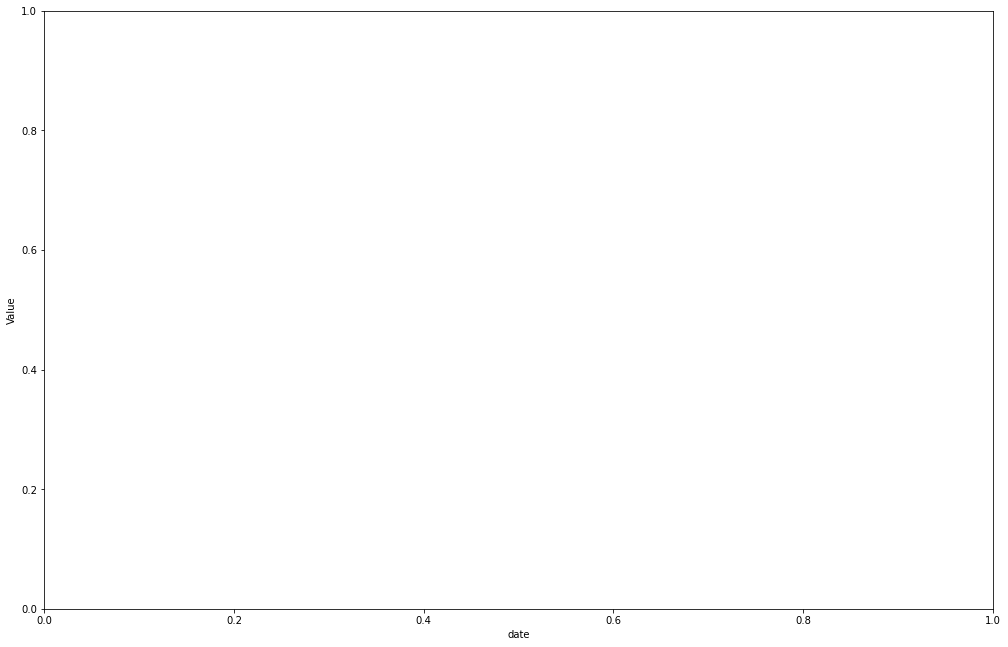

In [68]:
plt.figure(figsize=(17, 11))
plt.xlabel('date')
plt.ylabel('Value')

look_back=100
# Plot the original data
plt.plot(scaler.inverse_transform(df1), label='Original Data', )

# Plot the training predictions
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
plt.plot(trainPredictPlot, label='Training Predictions', color="green")

# Plot the testing predictions
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) :len(df1), :] = test_predict

plt.plot(testPredictPlot, label='Testing Predictions',color="red")


plt.legend(loc='upper right',fontsize='xx-large')
plt.show()

# Displaying predicted data for future Days

In [ ]:
len(test_data) #12 / Sep ---> 13rd Sep

In [30]:
# taking data from previous 100 days from 341 to 441(last data)
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
# convert Last 100 values to a list 

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [32]:
## 
lst_output =[]
n_steps = 100
i= 0

# while (i<30)